# VaR/CVaR Workbook: Details on linear, non-linear and swap portfolio level VaR calculation based on MC simulation.
--- Jul-15-2020, Alan, Shaolun.du@gmail.com

This is a detailed implementation and documentation on VaR calculation for stocks, stock options and swaps. 
Value at risk (VaR) is a measure of the risk of loss for investments. It estimates how much a set of investments might lose (with a given probability), given normal market conditions, in a set period such as a day. VaR is typically used by firms and regulators in the financial industry to gauge the amount of assets needed to cover possible losses.
For a given portfolio, time horizon, and probability p, the p VaR can be defined informally as the maximum possible loss during that time after we exclude all worse outcomes whose combined probability is at most p. This assumes mark-to-market pricing, and no trading in the portfolio.

For example, if a portfolio of stocks has a one-day 5% VaR of 1 million, that means that there is a 0.05 probability that the portfolio will fall in value by more than 1 million over a one-day period if there is no trading. Informally, a loss of 1 million or more on this portfolio is expected on 1 day out of 20 days ,because of 5% probability.

Common parameters for VaR are 1% and 5% probabilities and one day and two-week horizons.

There are three ways to calculate VaR: delta-normal method, historical method and monte carlo simulation method.
The pro/cons for them as a summary below:
- Delta-normal method: It works **only** on linear payoff portfolio, anything like options will not be able to apply on it, and is easy to compute but depends heavily on the assumption of normality of return distribution which is preey hard to be true nowadays. Most of the case, assets returns have fat tails so does the portfolio returns. A distribution check before running the method will be necessary. The formular looks like this: VaR = Z-value * Std(Portfolio), with Z(95%) = 1.65, Z(99%) = 2.33. Also, because we have to use historical std, it will subject to regime changes and this method will not be able to adjust for that.
- Historical method: This method is just like a back test to get all historical returns for a given time window and then count on the historical returns to arrive a VaR value. The good thing for this is all historical correlation and market information is reflected in the historical price which makes it soundness. But we can only assume the historical pattern will reply itself in order to beleive in this VaR value of historical returns. Most of the case historical will repeat itself in some degree but with some twitches. Also this method requires large data set of historical information and heavily computations.
- Monte Carlo method: This method use random number to simulate market movements based on some model assumptions. different MC setup will give different market simulation results so does VaR. The cruical part is to build a soundness simulation process which can appoximate market movements. The advantages of this is one can basically do whatever assumptions and let the model run. However, the biggest drawback is also hard to make a good market correlation assumption and computation requires always more than 2 hours to finish a medium size portfolio.

The last thing beforehand is CVaR. It stands for Conditional Value at Risk (CVaR), also known as the expected shortfall, is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has. CVaR is derived by taking a weighted average of the “extreme” losses in the tail of the distribution of possible returns, beyond the value at risk (VaR) cutoff point. Conditional value at risk is used in portfolio optimization for effective risk management.

**Now, ready to get hands dirty!**


In [16]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import OrderedDict
import yfinance as yf # Will need for stock data
import numpy as np
import pandas as pd
import datetime as dt
%matplotlib inline

## Module One - VaR for stocks portfolio (Linear payoff):

We will use yahoo finance data to construct a portoflio, also you can feel free to change the positions or holding in order to run your own VaR value.

Program will automatic generate plots of simulated return distribution and simulated portfolio value paths as well as max drawdown/up and max continues gains/loss periods distribution.

In this section we will assume stock returns are log-normally distributed see the dynamic belows:
- $ret\_ln = ln(ret_{i}/ret_{i-1})$
- $ret\_simu = exp((miu-1/2*sigmma^2)*delta_{t}+sigmma*delta_{t}^{0.5})*rand\_var$
- rand_var follows conditional multivariables normal distribution with correlation from historical returns.

In [2]:
class MC_VaR_Linear():
    """ This is a monte carlo simulator for stock portfolio
        based on the assumption stock returns are log normally distributed
        we will use historical returns and correlations to generate
        random stock price path.
    """
    def __init__(self, paras):
        self.T = paras["T"] # Maturity time
        self.N = paras["N"] # Total timestep to run
        self.S_N = paras["Simulation_num"] # Number of Simulation
        self.alpha = paras["alpha"]
        self.start_t = paras["start"]
        self.end_t = paras["end"]
        self.option_setting = paras.get("option_setting",0)
        self.portfolio = self._get_yahoo_data(paras["positions"])
        self.all_path = []
        self.Answer_bk = []
        
    def _start_MC_CstVar(self):
        # Start running all MC dynamics based on
        # constact variance assumption and fixed correlations
        returns = self.portfolio.pct_change().dropna()
        log_ret = np.log(1 + returns)
        miu,sigma = log_ret.mean(),log_ret.std()
        cov_mat = log_ret.corr()
        delta_t = self.T/self.N
        for case in range(self.S_N):
            # Get one portfolio simulation values list
            dynamic_t = self._get_one_MC_linear(miu,sigma,cov_mat,delta_t)
            # Save all portfolio value path
            self.all_path.append(dynamic_t)
            Stats_Dict = self._stat_collect(dynamic_t)
            # Stats_Dict has ticker+"PnL", ticker+... name style
            self.Answer_bk.append(Stats_Dict)
    
    def _get_one_MC_linear(self,miu,sigma,cov_mat,delta_t):
        # Generate one MC dynamic
        dynamics = {}
        y = self._corr_adjust_normal(cov_mat)
        s0 = self.portfolio.iloc[-1,:]
        for x in range(len(self.portfolio.columns)):
            ticker = self.portfolio.columns[x]
            temp = [s0[x]]
            for j in range(self.N):
                # Simulate returns based on previous value
                rets_simu = np.exp(((miu[x]-1/2*sigma[x]*sigma[x]) * delta_t + sigma[x] * np.sqrt(delta_t) * y[x][j]))
                temp.append(temp[-1]*rets_simu)
            dynamics[ticker] = temp
        # Sum of total portfolio value
        dyn_df = pd.DataFrame(dynamics).sum(axis=1).tolist()
        return dyn_df
    
    def _stat_collect(self, dynamic):
        # Statistics collector given returns
        # Functions: PnL, Volatility,
        #           Max_Drowndown, Max_Gain
        #           Longest down period (LDP), Longest up period (LUP)
        Ans_dict = {}
        Ans_dict["PnL"] = dynamic[-1]-dynamic[0] # dynamic is a list of portoflio values
        max_up,max_draw = self._cal_max_PnL_chg(dynamic)
        max_long,max_short = self._cal_max_period(dynamic)
        Ans_dict["Max_Up"] = max_up
        Ans_dict["Max_Down"] = max_draw
        Ans_dict["Max_Up_Period"] = max_long
        Ans_dict["Max_Down_Period"] = max_short
        return Ans_dict
    
    def _cal_max_PnL_chg(self, price):
        # Calculate max down/up
        run_min,run_max = price[0],price[0]
        max_down,max_up = float('inf'),float('-inf')
        for ele in price:
            run_min = min(run_min,ele)
            run_max = max(run_max,ele)
            max_up = max(ele-run_min,max_up)
            max_down = min(ele-run_max,max_down)
        return max_up,max_down
    
    def _cal_max_period(self,price):
        # Calculate max gain/loss period
        if len(price) == 1:
            return 0
        max_long,max_short = 0,0
        t_long,t_short = 0,0,
        for i in range(1,len(price)):
            # Assume price list longer than 1
            if price[i]>=price[i-1]:
                t_long += 1
            else:
                max_long = max(t_long,max_long)
                t_long = 0
            
            if price[i]<=price[i-1]:
                t_short += 1
            else:
                max_short = max(t_short,max_short)
                t_short = 0
                
        return max_long,max_short
    
    def _cal_VaR_alpha(self, PnL):
        # Calculate VaR based on simulated PnL
        VaR = np.quantile(sorted(PnL),self.alpha)
        tail = [ele for ele in PnL if ele <VaR]
        CVaR = sum(tail)/len(tail)
        return VaR,CVaR
    
    def _corr_adjust_normal( self, cov_mat ):
        # Correlated multi-variable normal
        y = np.random.multivariate_normal([0]*len(cov_mat),cov_mat,size=self.N)
        return y.T
    
    def _get_answer(self):
        # Return answers
        PnL = []
        max_up = []
        max_down = []
        up_period = []
        down_period = []
        for ele in self.Answer_bk:
            PnL.append(ele["PnL"])
            max_up.append(ele["Max_Up"])
            max_down.append(ele["Max_Down"])
            up_period.append(ele["Max_Up_Period"])
            down_period.append(ele["Max_Down_Period"])
        return PnL,max_up,max_down,up_period,down_period
    
    def _plot_VaR_Summary(self, **kwargs):
        fig, axs = plt.subplots(len(kwargs),1,figsize=(6,4*len(kwargs)))
        i_loc = 0
        for key, value in kwargs.items():
            VaR,CVaR = self._cal_VaR_alpha(value)
            n_bins = 50
            axs[i_loc].hist(value, bins=n_bins)
            axs[i_loc].axvline(x=VaR,color='r')
            axs[i_loc].axvline(x=CVaR,color='r')
            bottom, top = axs[i_loc].get_ylim()
            axs[i_loc].text(VaR,top*0.8,"VaR({}D,{:.0%}):{}".format(self.T,self.alpha,int(VaR)))
            axs[i_loc].text(VaR,top*0.6,"CVaR({}D,{:.0%}):{}".format(self.T,self.alpha,int(CVaR)))
            axs[i_loc].set_xlabel(key+"_Distribution")
            axs[i_loc].set_ylabel("Frequency")
            i_loc += 1
        return fig
    
    def _plot_all_path(self):
        fig, axs = plt.subplots(1,1,figsize=(6,4))
        for p in self.all_path:
            axs.plot(range(len(p)),p)
        axs.set_xlabel("Simulated Portfolio Value Path")
        axs.set_ylabel("Portfolio Value")
        return fig
    
    def _get_yahoo_data(self, positions):
        # Build own portfolio with yahoo data
        # Positions dictionary contains {"Ticker name":number of stock holds}
        ticker = list(positions.keys())
        data = yf.download(tickers=ticker, start=self.start_t, end=self.end_t)['Adj Close']
        if len(ticker) == 1:
            data = pd.DataFrame(data)
            data = data.rename(columns={'Adj Close':ticker[0]})
        for tic,weight in positions.items():
            data[tic] *= weight
        data = data.dropna()
        return data

In [3]:
# Please define your portfolio below,
# here I am using apple, facebook, amazon and google each one hold 1 share as example
# After define the historical start date and end date the simulation will be based on
# historical correlations and standard deviation as well as mean returns
positions = {"AAPL":1,"FB":1,"AMZN":1,"GOOG":1}
paras = {"T":1, # Days of Simulation
         "N":10, # Timestep granulation
         "Simulation_num": 10000, # Number of simulations
         "alpha":0.05, # alpha for VaR calculation
         "start":"2017-01-01", # history start date
         "end":"2020-07-13", # history end date
         "positions":positions, # position inputs
        }

[                       0%                       ]  4 of 4 completed


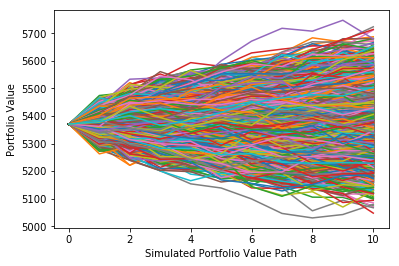

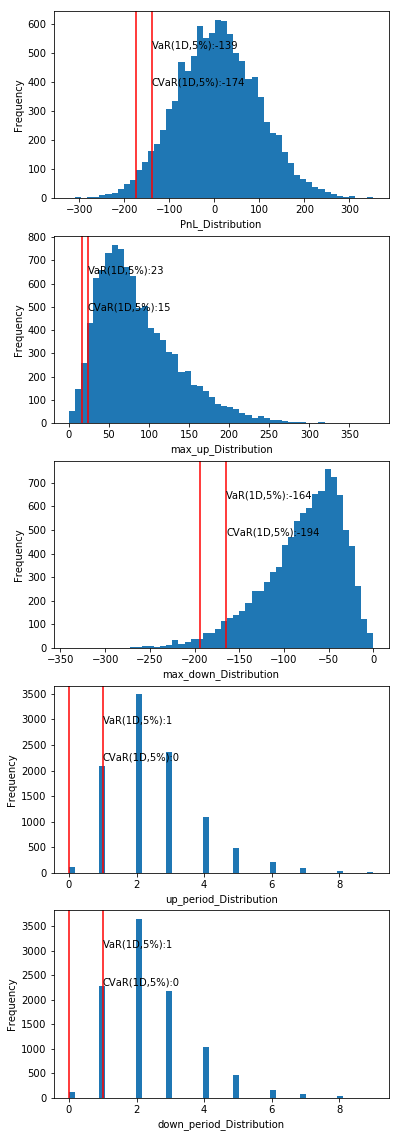

In [4]:
MC_simu = MC_VaR_Linear(paras)
dynamics = MC_simu._start_MC_CstVar()
PnL,max_up,max_down,up_period,down_period = MC_simu._get_answer()
title = "Portfolio_PnL_Distribution"
Fig0 = MC_simu._plot_all_path()
Fig1 = MC_simu._plot_VaR_Summary( PnL=PnL, max_up=max_up,
                                  max_down=max_down, up_period=up_period,
                                  down_period=down_period )

## Module Two - VaR for stock options portfolio (non-Linear payoff):

We will use yahoo finance data to construct option's underlying portoflio, also you can feel free to change the positions or holding in order to run your own VaR value. For stock options simulation, we are based on option price approximation delta-gamma-theta rules if you are not familiar with it, please get some basic knowledge from wiki.

Program will automatic generate plots of simulated return distribution and simulated portfolio value paths as well as max drawdown/up and max continues gains/loss periods distribution.

In this section we will assume stock returns are log-normally distributed see the dynamic belows:
- $ret\_ln = ln(ret_{i}/ret_{i-1})$
- $ret\_simu = exp((miu-1/2*sigmma^2)*delta_{t}+sigmma*delta_{t}^{0.5})*rand\_var$
- rand_var follows conditional multivariables normal distribution with correlation from historical returns.
- The option's price will be approximated by $\delta(S)*delta+0.5*gamma^2*\delta(S)+theta*\delta(t)$

The simulation process looks exactly the same as we previous did for linear payoff. However, now we are using price approxiamtion to get a price change for option given a price change and time change for underlying stock.

In [6]:
class MC_VaR_nonLinear():
    """ This is a monte carlo simulator for stock options portfolio
        based on the assumption stock returns are log normally distributed
        we will use historical returns and correlations to generate
        random stock price path.
        Then we approximate option price change using delta-gamma-theta rule.
    """
    def __init__(self, paras):
        self.T = paras["T"] # Maturity time
        self.N = paras["N"] # Total timestep to run
        self.S_N = paras["Simulation_num"] # Number of Simulation
        self.alpha = paras["alpha"]
        self.start_t = paras["start"]
        self.end_t = paras["end"]
        self.option_setting = paras.get("option_setting",0)
        self.portfolio = self._get_yahoo_data(paras["underlying"])
        self.all_path = []
        self.Answer_bk = []
        
    def _start_MC_CstVar(self):
        # Start running all MC dynamics based on
        # constact variance assumption and fixed correlations
        returns = self.portfolio.pct_change().dropna()
        log_ret = np.log(1 + returns)
        miu,sigma = log_ret.mean(),log_ret.std()
        cov_mat = log_ret.corr()
        delta_t = self.T/self.N
        for case in range(self.S_N):
            # Get one portfolio simulation values list
            dynamic_t = self._get_one_MC_nonlinear( miu,sigma,cov_mat,delta_t,
                                                    self.option_setting)
            # save all path of portfolio values
            self.all_path.append(dynamic_t)
            Stats_Dict = self._stat_collect(dynamic_t)
            # Stats_Dict has ticker+"PnL", ticker+... name style
            self.Answer_bk.append(Stats_Dict)
    
    def _get_one_MC_nonlinear(self,miu,sigma,cov_mat,delta_t,option_para):
        # Generate one MC dynamic
        dynamics = {}
        delta = option_para["delta"]
        gamma = option_para["gamma"]
        theta = option_para["theta"]
        y = self._corr_adjust_normal(cov_mat)
        opt_s0 = option_para["price_0"]
        s0 = self.portfolio.iloc[-1,:]
        for x in range(len(self.portfolio.columns)):
            ticker = self.portfolio.columns[x]
            temp_opt = [opt_s0[x]]
            temp_stock = [s0[x]]
            for j in range(self.N):
                # Take N steps to accomplish T time
                rets_simu = np.exp(((miu[x]-1/2*sigma[x]*sigma[x]) * delta_t + sigma[x] * np.sqrt(delta_t) * y[x][j]))
                # Additional leayer for option price vhanges
                ds = (rets_simu-1)*temp_stock[-1]
                ds_opt = delta[x]*ds+1/2*gamma[x]**2*ds+theta[x]*delta_t
                temp_stock.append(temp_stock[-1]*rets_simu)
                temp_opt.append(ds_opt + temp_opt[-1])
            dynamics[ticker] = temp_opt
        dyn_df = pd.DataFrame(dynamics).sum(axis=1).tolist()
        return dyn_df
    
    def _stat_collect(self, dynamic):
        # Statistics collector given returns
        # Functions: PnL, Volatility,
        #           Max_Drowndown, Max_Gain
        #           Longest down period (LDP), Longest up period (LUP)
        Ans_dict = {}
        Ans_dict["PnL"] = dynamic[-1]-dynamic[0] # dynamic is a list of portoflio values
        max_up,max_draw = self._cal_max_PnL_chg(dynamic)
        max_long,max_short = self._cal_max_period(dynamic)
        Ans_dict["Max_Up"] = max_up
        Ans_dict["Max_Down"] = max_draw
        Ans_dict["Max_Up_Period"] = max_long
        Ans_dict["Max_Down_Period"] = max_short
        return Ans_dict
    
    def _cal_max_PnL_chg(self, price):
        # Calculate max down/up
        run_min,run_max = price[0],price[0]
        max_down,max_up = float('inf'),float('-inf')
        for ele in price:
            run_min = min(run_min,ele)
            run_max = max(run_max,ele)
            max_up = max(ele-run_min,max_up)
            max_down = min(ele-run_max,max_down)
        return max_up,max_down
    
    def _cal_max_period(self,price):
        # Calculate max gain/loss period
        if len(price) == 1:
            return 0
        max_long,max_short = 0,0
        t_long,t_short = 0,0,
        for i in range(1,len(price)):
            # Assume price list longer than 1
            if price[i]>=price[i-1]:
                t_long += 1
            else:
                max_long = max(t_long,max_long)
                t_long = 0
            
            if price[i]<=price[i-1]:
                t_short += 1
            else:
                max_short = max(t_short,max_short)
                t_short = 0
                
        return max_long,max_short
    
    def _cal_VaR_alpha(self, PnL):
        # Calculate VaR based on simulated PnL
        VaR = np.quantile(sorted(PnL),self.alpha)
        tail = [ele for ele in PnL if ele <VaR]
        CVaR = sum(tail)/len(tail)
        return VaR,CVaR
    
    def _corr_adjust_normal( self, cov_mat ):
        # Correlated multi-variable normal
        y = np.random.multivariate_normal([0]*len(cov_mat),cov_mat,size=self.N)
        return y.T
    
    def _get_answer(self):
        PnL = []
        max_up = []
        max_down = []
        up_period = []
        down_period = []
        for ele in self.Answer_bk:
            PnL.append(ele["PnL"])
            max_up.append(ele["Max_Up"])
            max_down.append(ele["Max_Down"])
            up_period.append(ele["Max_Up_Period"])
            down_period.append(ele["Max_Down_Period"])
        return PnL,max_up,max_down,up_period,down_period
    
    def _plot_all_path(self):
        fig, axs = plt.subplots(1,1,figsize=(6,4))
        for p in self.all_path:
            axs.plot(range(len(p)),p)
        axs.set_xlabel("Simulated Portfolio Value Path")
        axs.set_ylabel("Portfolio Value")
        return fig
    
    def _plot_VaR_Summary(self, **kwargs):
        fig, axs = plt.subplots(len(kwargs),1,figsize=(6,4*len(kwargs)))
        i_loc = 0
        for key, value in kwargs.items():
            VaR,CVaR = self._cal_VaR_alpha(value)
            n_bins = 50
            axs[i_loc].hist(value, bins=n_bins)
            axs[i_loc].axvline(x=VaR,color='r')
            axs[i_loc].axvline(x=CVaR,color='r')
            bottom, top = axs[i_loc].get_ylim()
            axs[i_loc].text(VaR,top*0.8,"VaR({}D,{:.0%}):{}".format(self.T,self.alpha,int(VaR)))
            axs[i_loc].text(CVaR,top*0.6,"CVaR({}D,{:.0%}):{}".format(self.T,self.alpha,int(CVaR)))
            axs[i_loc].set_xlabel(key+"_Distribution")
            axs[i_loc].set_ylabel("Frequency")
            i_loc += 1
        return fig
    
    def _get_yahoo_data(self, positions):
        # Build own portfolio with yahoo data
        # Positions dictionary contains {"Ticker name":number of stock holds}
        ticker = list(positions.keys())
        data = yf.download(tickers=ticker, start=self.start_t, end=self.end_t)['Adj Close']
        if len(ticker) == 1:
            data = pd.DataFrame(data)
            data = data.rename(columns={'Adj Close':ticker[0]})
        for tic,weight in positions.items():
            data[tic] *= weight
        data = data.dropna()
        return data

In [7]:
# Please define your portfolio below,
# here I am using apple, facebook, amazon and google each one hold 1 share as example
# After define the historical start date and end date the simulation will be based on
# historical correlations and standard deviation as well as mean returns
# Also after define the underlying please also input corresponding option greek letters
underlying = {"AAPL":1,"FB":1,"AMZN":1,"GOOG":1}
options_setting = {
         "price_0":[2977,2042,11830,14500], # current option price
         "delta":  [60,56,31,79], # each deltas
         "gamma":  [2.5,2.1,1.8,1.9], # each gammas
         "theta":  [-15.8,-12.6,-162.5,-47.5], # each thetas
        }
paras = {"T":1, # Days of Simulation
         "N":10, # Timestep granulation
         "Simulation_num": 10000,
         "alpha":0.05,
         "start":"2017-01-01",
         "end":"2020-07-13",
         "underlying": underlying,
         "option_setting": options_setting,
        }

[**********************75%***********            ]  3 of 4 completed


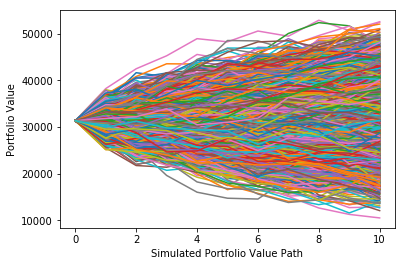

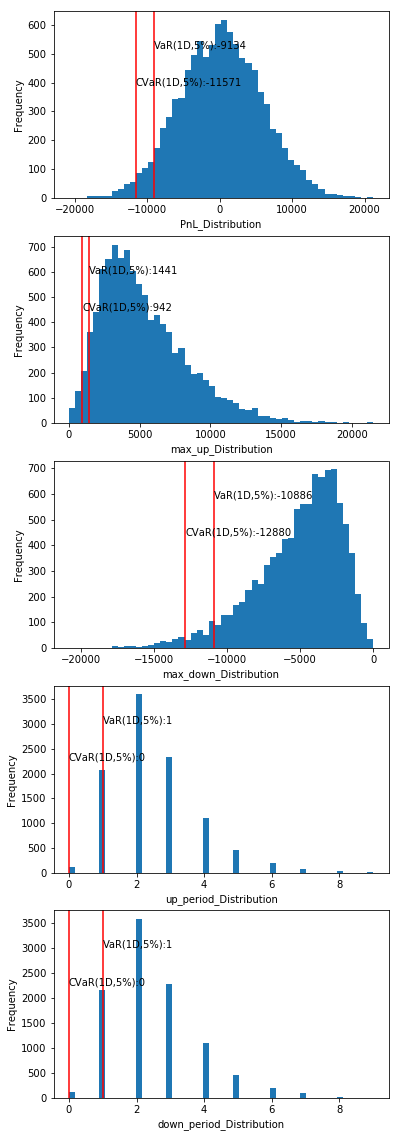

In [8]:
MC_simu = MC_VaR_nonLinear(paras)
dynamics = MC_simu._start_MC_CstVar()
PnL,max_up,max_down,up_period,down_period = MC_simu._get_answer()
title = "Portfolio_PnL_Distribution"
Fig0 = MC_simu._plot_all_path()
Fig1 = MC_simu._plot_VaR_Summary( PnL=PnL,max_up=max_up,
                                  max_down=max_down,up_period=up_period,
                                  down_period=down_period)


## Module Three - VaR for swaps portfolio (yield curve building and full re-pricing):

This section is complicated and will involve several components: yield curve bootstrapping, market rates dynamics simulation and swap portfolio repricing.

If you are not familar with yield curve bootstrapping and swap pricing please refer to my previous post. However, here to simplify things, I will use only swaps contructs to construct the yield curve. Please note that the usual way to bootstrap a yield curve is based on most liquidity contracts from deposits rates, future rates and swap rates in the long end. Now, I will only use swap 1y, 2y, 5y, 10y, 15y, 20y and 30y.

In the following, let's get all tools function in place:

In [12]:
class Day_Counter:
    _dc_norm = dict( {
                '30/360': '30/360',
                'BD/252': 'BD/252',
                '28/360': '28/360',
                '30/360 US': '30/360 US',
                '30U/360': '30/360 US',
                '360/360': '30/360 US',
                '30E/360': '30E/360',
                '30E/360 ISDA': '30E/360 ISDA',
                '30E+/360': '30E+/360',
                'ACTUAL/365': 'ACTUAL/ACTUAL ISDA',
                'ACT/365': 'ACTUAL/ACTUAL ISDA',
                'ACT/ACT': 'ACTUAL/ACTUAL ISDA',
                'ACTUAL/ACTUAL': 'ACTUAL/ACTUAL ISDA',
                'ACTUAL/365 FIXED': 'ACTUAL/365 FIXED',
                'ACT/365 FIXED': 'ACTUAL/365 FIXED',
                'ACTUAL/360': 'ACTUAL/360',
                'ACT/360': 'ACTUAL/360',
                } )
    def __init__( self,
                  convention):
        self.convention = convention
    def get_convention(self):
        return self.convention
    def set_convention( self, 
                        convention ):
        self.convention = convention
    def set_convention_by_ccy( self,
                               ccy ):
        if ccy.upper() in ("USD","EUR","GBP"):
            self.convention = '30/360'
        elif ccy.upper() in ("COP","CHF"):
            self.convention = 'ACT/360'
        elif ccy.upper() in ("JPY"):
            self.convention = 'ACT/365'
        elif ccy.upper() in ("BRL"):
            self.convention = 'ACT/252'
        
    def yearfrac( self, 
                  dt1, 
                  dt2, 
                  convention="", 
                  **kwargs):
        """ Fractional number of years between two dates 
            according to a given daycount convention
            It can take inputs convention 
            Otherwise use default convention
        """
        if convention == "":
            frac = self._daycount_parameters( dt1, 
                                              dt2, 
                                              self.convention, 
                                              **kwargs)[2]
        else:
            frac = self._daycount_parameters( dt1, 
                                              dt2, 
                                              convention, 
                                              **kwargs)[2]
        return frac
    
    def _daycount_parameters( self, 
                              dt1, 
                              dt2, 
                              convention, 
                              **kwargs):
        """ Return number of days and total 
            number of days (i.e. numerator and
            denominator in the counting of year 
            fraction between dates
        """
        convention = convention.upper()
        convention = self._normalize_daycount_convention( convention )
        y1, m1, d1 = dt1.year, dt1.month, dt1.day
        y2, m2, d2 = dt2.year, dt2.month, dt2.day
        factor = None
        if convention in {'30/360','30/360 US', '30E/360', '30E/360 ISDA', '30E+/360'}:
            if convention == '30/360':
                d1 = min (d1,30)
                if d1 == 30:
                    d2 = min(d2,30)
            elif convention == '30/360 US':
                # US adjustments
                if m1 == 2 and d1 >= 28:
                    d1 = 30
                if m2 == 2 and d2 >= 28:
                    d2 = 30
                if d2 == 31 and d1 >= 30:
                    d2 = 30
                if d1 == 31:
                    d1 = 30
            elif convention == '30E+/360':
                if d1 == 31:
                    d1 = 30
                if d2 == 31:
                    m2 += 1
                    if m2 == 13:
                        m2 = 1
                        y2 += 1
                    d2 = 1
            num_days  = (360*(y2-y1)+30*(m2-m1)+(d2-d1))
            year_days = 360
        elif convention == "28/360":
            d1 = min (d1,30)
            if d1 == 30:
                d2 = min(d2,28)
            num_days  = (360*(y2-y1)+28*(m2-m1)+(d2-d1))
            year_days = 360
        elif convention in {'ACTUAL/365 FIXED', 'ACTUAL/365'}:
            num_days  = (dt2-dt1).days
            year_days = 365
        elif convention == 'ACTUAL/360':
            num_days  = (dt2-dt1).days
            year_days = 360
        elif convention == 'ACTUAL/365L':
            yearly_frequency = 'frequency' in kwargs and kwargs['frequency'] =='yearly'
            if yearly_frequency:
                year_days = 366 if self._period_has_29feb(dt1, dt2) else 365
            else:
                year_days = 366 if calendar.isleap(dt2) else 365
            num_days = (dt2-dt1).days
        elif convention == "BD/252":
            year_days = 252
            num_days = np.busday_count( dt1, dt2 )
        elif convention == 'ACTUAL/ACTUAL AFB':
            year_days = 366 if self._period_has_29feb(dt1, dt2) else 365
            num_days  = (dt2-dt1).days
            
        elif convention == 'ACTUAL/ACTUAL ISDA':
            num_days  = 0
            year_days = 0
            if y2 == y1:
                num_days  = (dt2 - dt1).days
                year_days = 365.25
            else:
                """ we need to calculate factor properly
                """
                factor = 0.0
                """ full years between y1 and y2 exclusive
                """
                for y in range(y1+1, y2):
                    yd = 365.25
                    num_days  += yd
                    year_days += yd
                    factor += float(num_days)/year_days
                """ Days in the remaining part of the first year
                """
                num = (datetime.datetime(y1+1, 1, 1).date() - dt1).days
                den = 365.25
                num_days  += num
                year_days += den
                factor += float(num)/den
                """ Days in the beginning of the last year
                """
                num = (dt2 - datetime.datetime(y2, 1, 1).date()).days
                den = 365.25
                num_days += num
                year_days += den
                factor += float(num)/den
        else:
            raise ValueError('Unknown daycount convention \'%s\'' % convention)
    
        if factor is None:
            factor = float(num_days)/year_days
        return num_days, year_days, factor

    def _normalize_daycount_convention( self, 
                                        convention ):
        convention = convention.upper()
        return self._dc_norm[convention]
    
    def _period_has_29feb( self, 
                           dt1, 
                           dt2 ):
        have_29_feb = False
        y1 = dt1.year
        y2 = dt2.year
        for y in range(y1, y2+1):
            if calendar.isleap(y) and (
                (y!=y1 and y!=y2)
                or (y == y1 and dt1<datetime.datetime(y1, 2, 29))
                or (y == y2 and datetime.datetime(y2, 2, 29) <= dt2)):
                have_29_feb = True
        return have_29_feb    
    def daydiff( self, 
                 dt1, 
                 dt2, 
                 convention, 
                 **kwargs ):
        """ Calculate difference in days between tow days according to a given
            daycount convention
        """
        return self._daycount_parameters( dt1, 
                                          dt2, 
                                          convention, 
                                          **kwargs )[0]

In [20]:
""" This function is used to do bootstrapping 
    based on simple swap rates market without
    deposits market and futures market,
    This is an example on VaR calculation with 
    monte carlo simulation based on historical
    key rates markets correlations.
    Author: Alan
    Contact: Shaolun.du@gmail.com
    Date: 12/31/2018
"""
BS_Con = { 
    "USD":{ "Swap":   "30/360","Swap_Freq": 2,},
    "EUR":{ "Swap":   "30/360","Swap_Freq": 1,},
    "GBP":{ "Swap":   "30/360","Swap_Freq": 2,},
    "JPY":{ "Swap":   "ACT/365","Swap_Freq": 2,},
    "CHF":{ "Swap":   "ACT/360","Swap_Freq": 1,},
    'CAD':{ "Swap":   "ACT/365","Swap_Freq": 2,},
    }

from datetime import datetime as datetime
from dateutil.relativedelta import relativedelta
from Day_Counter_V2 import Day_Counter as DC

def interpolation_act( cur_time, 
                       start_time, 
                       start_value, 
                       end_time, 
                       end_value ):
    """ Interpolation function based on time location
    """
    return start_value + \
        (end_value-start_value)*(cur_time-start_time)/(end_time-start_time)

def augument_by_frequency( input_list, 
                           months ):
    """ Inputs dates should be at least half year seperated
    """
    ans_list  = []
    cur_date  = input_list[0][0]
    cur_value = input_list[0][1] 
    interp_rate = cur_value
    time_frequency = relativedelta( months = months )
    ans_list.append((cur_date,cur_value))
    next_date = cur_date + time_frequency
    for i in range(1, len(input_list)):
        while next_date <= input_list[i][0]:
            interp_rate = interpolation_act( next_date,
                                             cur_date,
                                             cur_value,
                                             input_list[i][0],
                                             input_list[i][1] )
            ans_list.append( (next_date,interp_rate) )
            next_date += time_frequency
        cur_date  = input_list[i][0]
        cur_value = input_list[i][1]
    return ans_list

def boot_strapping_LIBOR( sdate,
                          ccy,
                          instruments
                          ):
    Day_Counter = DC("")
    # Assume the day count convention is always ACT/360
    # It will be changed when fully implementated
    def str_2_date( sdate ):
        """ Convet date string into datatime
        """
        if isinstance( sdate, str ):
            for fmt in ( "%Y-%m-%d", "%m/%d/%Y" ):
                try:
                    return datetime.strptime( sdate, fmt ).date()
                except ValueError:
                    pass
        else:
            return sdate
    """ Preliminary paramaters set ups instruments 
        = {[maturity,rates]...}
    """
    convention = BS_Con[ccy]
    swap_freq  = convention["Swap_Freq"]
    Day_Counter.set_convention(convention["Swap"])
    sdate = str_2_date( sdate )
    # To simplify we will treat 1 year swap as cash rate
    Cash_Rate = instruments[0]
    Swap_Rate = instruments[1:]
    ans_curve = []
    ans_curve.append([sdate,1])
    ans_curve.append([Cash_Rate[0],1/(1+Cash_Rate[1]*Day_Counter.yearfrac( sdate, Cash_Rate[0] )/100)])
    Swap_Rate = augument_by_frequency( Swap_Rate, int(12/swap_freq) )
    sum_df = 0
    swap_frequency = relativedelta( months = int(12/swap_freq) )
    """ Move cur_date back to do bootstrapping
    """
    cur_date = sdate
    for i in range( 1, len(ans_curve) ):
        while cur_date+swap_frequency+relativedelta(days=3) < Swap_Rate[0][0] \
            and cur_date >= ans_curve[i-1][0] \
            and cur_date < ans_curve[i][0]:
                nxt_date = cur_date+swap_frequency
                yearfrac = Day_Counter.yearfrac( cur_date, nxt_date )
                for l in range( 1, len(ans_curve) ):
                    if nxt_date >= ans_curve[l-1][0] \
                        and nxt_date < ans_curve[l][0]:
                        DF = interpolation_act( nxt_date, ans_curve[l-1][0],
                                                ans_curve[l-1][1], ans_curve[l][0],
                                                ans_curve[l][1] )
                sum_df += DF*yearfrac
                if nxt_date > ans_curve[-1][0]:
                    ans_curve.append([nxt_date,DF])
                cur_date += swap_frequency
    cur_date = Swap_Rate[0][0]
    for i in range( 0, len(Swap_Rate) ):
        if sum_df == 0:
            print("Warning Cannot get correct 0.5y, 1y and 1.5y discount factors...")
            print("Current Date:"+str(cur_date))
            print(ccy)
            print(ans_curve)
        """ Sum of previous discount 
            factors stored in "sum_df"
        """
        nxt_date = cur_date+swap_frequency
        yearfrac = Day_Counter.yearfrac( cur_date, nxt_date )
        rates    = Swap_Rate[i][1]
        cur_DF   = (100-sum_df*rates)/(100+rates*yearfrac)
        ans_curve.append([cur_date,cur_DF])
        sum_df   += cur_DF*yearfrac
        cur_date += swap_frequency
        
    sorted_discount_curve = sorted( ans_curve, key = lambda tup: tup[0] )
    return sorted_discount_curve

In [22]:
class MC_VaR_Swap():
    def __init__(self, paras):
        self.T = paras["T"] # Maturity time
        self.N = paras["N"] # Total timestep to run
        self.S_N = paras["Simulation_num"] # Number of Simulation
        self.alpha = paras["alpha"]
        self.portfolio = paras["positions"]
        self.rate_market = self._get_excel_data("US_SW_Market.csv")[paras["start"]:paras["end"]]
        self.s0 = self.rate_market.iloc[-1]
        self.all_cvs = []
        self.Answer_bk = []
        
    def _start_MC_CstVar(self):
        # Start running all MC dynamics based on
        # constact variance assumption and fixed correlations
        returns = self.rate_market.diff().dropna()
        miu,sigma = returns.mean(),returns.std()
        cov_mat = returns.corr()
        delta_t = self.T/self.N
        price_0 = self._reprice_dynamic(self.s0.to_list(),self.portfolio)
        answer = []
        for case in range(self.S_N):
            # Get one portfolio simulation values list
            dynamic_t = self._get_one_MC_linear(miu,sigma,cov_mat,delta_t)
            self.all_cvs.append(dynamic_t)
            # Reprice swap portoflio based on dynamics
            price_t = self._reprice_dynamic(dynamic_t,self.portfolio)
            # Statistic collector
            PnL = [e1-e2 for e1,e2 in zip(price_t,price_0)]
            # Stats_Dict has ticker+"PnL", ticker+... name style
            answer.append(PnL)
        
        self.Answer_bk = np.sum(np.array(answer).T,axis=0).tolist()
        
    def _get_one_MC_linear(self,miu,sigma,cov_mat,delta_t):
        # Generate one MC dynamic
        dynamics = {}
        y = self._corr_adjust_normal(cov_mat)
        s0 = self.s0
        for x in range(len(self.rate_market.columns)):
            ticker = self.rate_market.columns[x]
            temp = [s0[x]]
            for j in range(self.N):
                # Simulate returns based on previous value
                rets_del = miu[x] * delta_t + sigma[x] * np.sqrt(delta_t) * y[x][j]
                temp.append(temp[-1]+rets_del)
            dynamics[ticker] = temp
        dyn_df = pd.DataFrame(dynamics).iloc[-1].to_list()
        return dyn_df
    
    def _reprice_dynamic(self, dynamic_t, portfolio ):
        # Reprice portfolio based on dynamics
        # Assume dynamic is onnly swaps with maturity 1,2
        answer = []
        ccy = portfolio["ccy"]
        sdate = portfolio["sdate"]
        dynamic_t = self._gen_dyn_market(sdate, dynamic_t)
        y_c = boot_strapping_LIBOR(sdate,ccy,dynamic_t)
        # We always assume floating leg is not start yet
        for name,pos in portfolio["pos"].items():
            sw_cf_tb = self._gen_sw_cf_tab(sdate, pos)
            NPV = self._NPV_CF(sw_cf_tb,y_c)
            answer.append(NPV)
        return answer
    
    def _NPV_CF(self, cash_flow,disct_curve):
        def interpolation_act( cur_time, start_time, 
                               start_value, end_time, end_value ):
            """ Interpolation function based on time location
            """
            return start_value + \
                (end_value-start_value)*(cur_time-start_time)/(end_time-start_time)

        # Calculate NPV of a given swap
        NPV      = 0
        cf_loc   = 0
        curve_start = disct_curve[0][0]
        base_df = 1
        while cash_flow[cf_loc][0] < curve_start:
            """ Cash flow may start back dated 
                make sure NPV caculation only
                starts when cash flow is in the current range
            """
            cf_loc += 1
            
        for loc in range(1, len(disct_curve)):
            pre_point = disct_curve[loc-1]
            cur_point = disct_curve[loc]
            if cf_loc < len(cash_flow):
                cf_point  = cash_flow[cf_loc] 
            else:
                break
            """ Whenever get a hit walking through all suitable cases
            """
            while cf_point[0] >= pre_point[0] \
                and cf_point[0] < cur_point[0]:
                    DF   = interpolation_act( cf_point[0],
                                              pre_point[0],
                                              pre_point[1],
                                              cur_point[0],
                                              cur_point[1] )
                    NPV += DF*cf_point[1]/base_df
                    if cf_loc + 1 >= len(cash_flow):
                        break
                    cf_loc   += 1
                    cf_point  = cash_flow[cf_loc] 
                    
        return NPV
    
    def _gen_sw_cf_tab(self, sdate, pos):
        # Generate fixed payment swap CF table
        if pos["style"].upper() == "PAY":
            multi = -1
        else:
            multi = 1
        freq = pos["fix_freq"]
        swp_start = sdate+relativedelta(years = pos["start"])
        tb_fix = [[swp_start,-multi*pos["notional"]]]
        for t in range(1,int((pos["maturity"]-pos["start"])*12/freq)):
            tb_fix.append([tb_fix[-1][0]+relativedelta(months = freq),multi*pos["notional"]*pos["rate"]/12*freq])
        tb_fix[-1][1] += multi*pos["notional"]
        return tb_fix
    
    def _gen_dyn_market(self, sdate, dynamic_t):
        # Assume we only use 1,2,5,10,15,20,30 maturity
        time_li = [sdate+relativedelta(years = 1),sdate+relativedelta(years = 2),
                   sdate+relativedelta(years = 5),sdate+relativedelta(years = 10),
                   sdate+relativedelta(years = 15),sdate+relativedelta(years = 20),
                   sdate+relativedelta(years = 30)]
        return [[e1,e2] for e1,e2 in zip(time_li,dynamic_t)]

    def _cal_VaR_alpha(self, PnL):
        # Calculate VaR based on simulated PnL
        VaR = np.quantile(sorted(PnL),self.alpha)
        tail = [ele for ele in PnL if ele <VaR]
        CVaR = sum(tail)/len(tail)
        return VaR,CVaR
    
    def _corr_adjust_normal( self, cov_mat ):
        # Correlated multi-variable normal
        y = np.random.multivariate_normal([0]*len(cov_mat),cov_mat,size=self.N)
        return y.T
    
    def _get_answer(self):
        return self.Answer_bk
    
    def _plot_cv_simulation(self):
        fig, axs = plt.subplots(2,1,figsize=(6,4*2))
        for cv in self.all_cvs:
            axs[0].plot(range(len(cv)),cv)
            axs[0].set_xlabel("Key Rate Counts")
            axs[0].set_ylabel("Swap Rates Curve simulation")
        axs[1].hist([ele[0] for ele in self.all_cvs],bins=50)
        axs[1].set_xlabel("Distribution of Y01 simulation")
        axs[1].set_ylabel("Rates")
        return fig
    
    def _plot_VaR_Summary(self, PnL):
        fig, axs = plt.subplots(1,1,figsize=(6,4))
        VaR,CVaR = self._cal_VaR_alpha(PnL)
        n_bins = 50
        axs.hist(PnL, bins=n_bins)
        axs.axvline(x=VaR,color='r')
        axs.axvline(x=CVaR,color='r')
        bottom, top = axs.get_ylim()
        axs.text(VaR,top*0.8,"VaR({}D,{:.0%}):{}".format(self.T,self.alpha,int(VaR)))
        axs.text(CVaR,top*0.6,"CVaR({}D,{:.0%}):{}".format(self.T,self.alpha,int(CVaR)))
        axs.set_xlabel("PnL_Distribution")
        axs.set_ylabel("Frequency")
        return fig
    
    def _get_excel_data(self, f_name ):
        # Build own portfolio with yahoo data
        # Positions dictionary contains {"Ticker name":number of stock holds}
        data = pd.read_csv(f_name).set_index("Dates")
        data.index = pd.to_datetime(data.index)
        return data

In [23]:
# Please define your portfolio below,
# here I am using 2 USD swaps with 0Y5Y pay 0.3% and 2Y7Y rec 0.25% as example.
positions = {
            "sdate":dt.datetime(2020,7,14),
            "ccy": "USD",
            "pos":{
                "Swap1":{ "start":0, "maturity":5,
                          "notional":1000000, "rate":0.003,
                          "style":"pay", "fix_freq":6 },
                "Swap2":{ "start":2, "maturity":9,
                          "notional":1000000, "rate":0.0025,
                          "style":"rec", "fix_freq":6 },
                },
            }
paras = {"T":1, # Days of Simulation
         "N":5, # Timestep granulation
         "Simulation_num": 10000,
         "alpha":0.05,
         "start":dt.datetime(2019,1,1),
         "end":dt.datetime(2020,7,13),
         "positions":positions,
        }

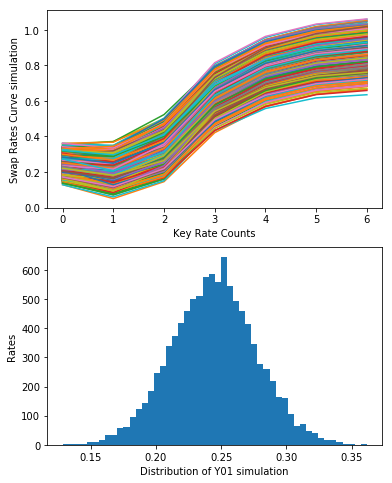

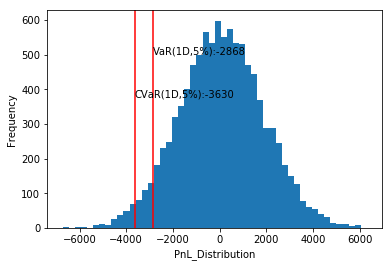

In [24]:
MC_simu = MC_VaR_Swap(paras)
dynamics = MC_simu._start_MC_CstVar()
PnL = MC_simu._get_answer()
Fig1 = MC_simu._plot_cv_simulation()
Fig2 = MC_simu._plot_VaR_Summary(PnL)

## Summary of VaR calculation

We have done three VaR calculations so far. For stock portfolio, we assume the price dynamic follows log-normal distribution, stock option portfolio also based on stock price return in log normal distribution and we apply delta-gamma-theta rule to approximate its return and the last one is a swap portfolio and we have to construct yield curve and do rate market simulation.